In [39]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Body,Mars, Earth, Moon, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.twobody.events import (
    AltitudeCrossEvent,
    LatitudeCrossEvent,
    NodeCrossEvent,
    PenumbraEvent,
    UmbraEvent,
    LithobrakeEvent
)

from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

In [40]:
body=Europa
R=body.R.to(u.km).value

###LM specs
m_wet = 150000
isp = 380*9.81 #actually exhaust velocity
thrust = 850000 #in N

thresh_alt = 0
altitude_cross_event = LithobrakeEvent(R,terminal = False)  # Set up the event.
events = [altitude_cross_event]

orb=Orbit.from_classical(body, (50+R)*u.km, 0.055*u.one, 0*u.deg, 0*u.deg,0*u.deg, 180*u.deg)
engine_active = True

def acc_thrust(t):
    m=m_wet - (thrust*t) / isp  
    return -0.001*thrust/m

t_f = 600/86400

def f(t0, state, k):
    global engine_active
    du_kep = func_twobody(t0, state, k)
    v = state[3:]
    speed = np.linalg.norm(v)
    if speed>0.0003 and engine_active:
        a =  acc_thrust(t0)*v/(speed)#its in km/s lol
    else:
        a= np.array([0,0,0])
        engine_active = False
    alt = np.linalg.norm(state[0:3]) - R
    # print(a)
    du_ad = np.array([0, 0, 0, a[0], a[1], a[2]])
    return du_kep + du_ad

tofs = TimeDelta(np.linspace(0, t_f, num=1000))
method=CowellPropagator(rtol=1e-6, f=f, events = events)


def calculate_lithobrake_velocity(t_ignition):
    global engine_active
    engine_active = True
    #propagate to ignition time
    doi_orb = orb.propagate(t_ignition)
    ephem2 = doi_orb.to_ephem(
        EpochsArray(doi_orb.epoch + tofs, method)
    )
        
    ephem_alts = norm(ephem2.rv()[0],axis=1).value-R
    ephem_vels = norm(ephem2.rv()[1],axis=1)
    landed_index = np.absolute(ephem_alts).argmin()
    lithobrake_velocity = ephem_vels[landed_index]
    return lithobrake_velocity.value

print(calculate_lithobrake_velocity(700*u.s))

resolution = 1000#1000 different suicide burns
start_times = np.linspace(2220, 2480, num=resolution)*u.s
landing_vels = np.empty(resolution)
for i in range(len(start_times)):
    landing_vel = calculate_lithobrake_velocity(start_times[i])
    # print(landing_vel)
    landing_vels[i]=landing_vel
# print(landing_vels)

best_descent_start = start_times[np.argmin(landing_vels)]
print(f"Best descent start time: {best_descent_start}, with landing velocity {np.min(landing_vels)} km/s")

# print(f"Lithobraked at t = {tofs[landed_index].to(u.s)} with v = {ephem_vels[landed_index]}")

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π



0.47769956352753845
Best descent start time: 2312.132132132132 s, with landing velocity 0.010185988009729556 km/s


[  686.43512592 -1401.74844546     0.        ] km
Lithobraked at t = 217.4174174174174 s with v = 0.010185988009729556 km / s
Propellant used: 49574.76 kg which was 1495.67 m/s of delta-v
Descent orbit: 1522 x 1699 km x 0.0 deg orbit around Europa (☾) at epoch J2000.000 (TT)


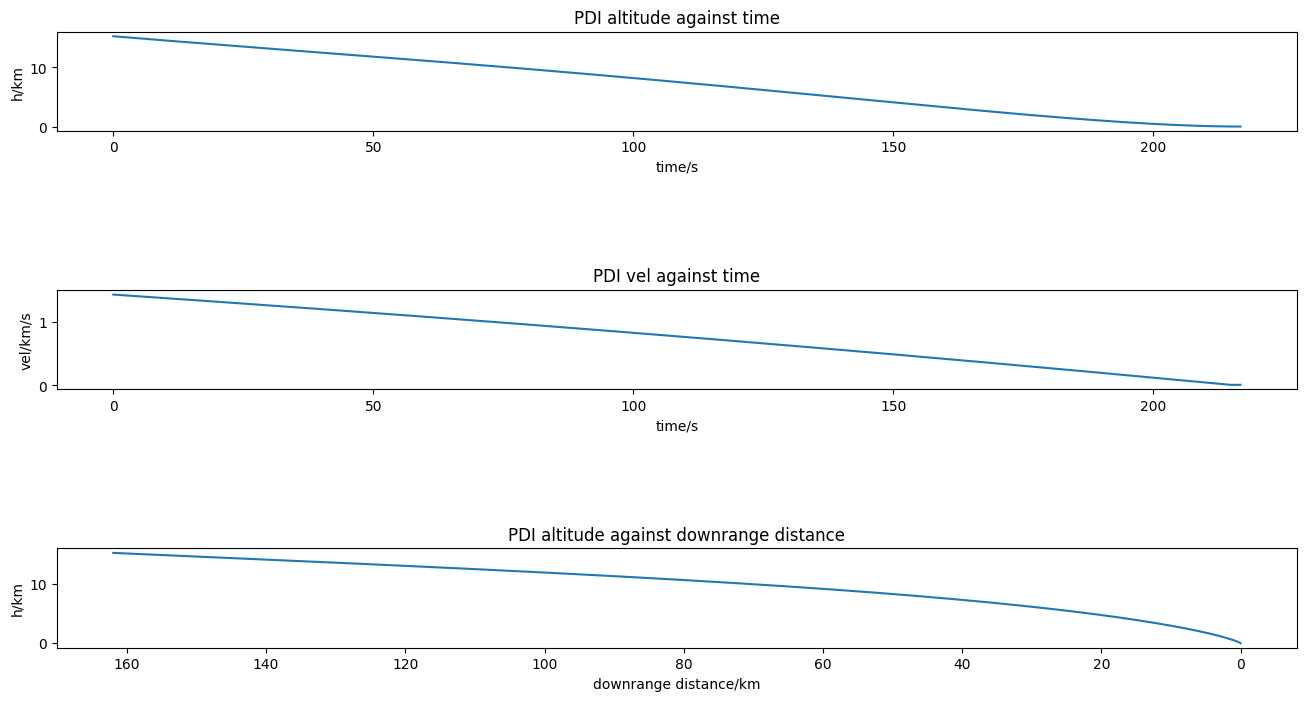

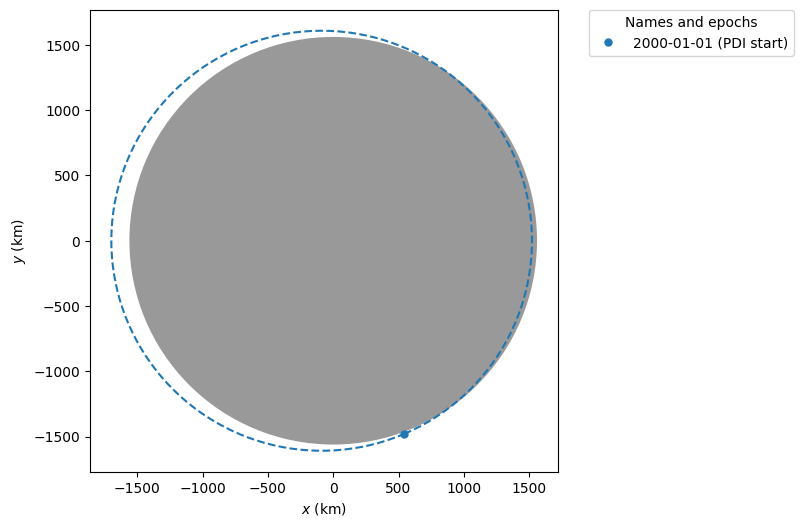

In [44]:
# best_descent_start = 3550
doi_orb = orb.propagate(best_descent_start)
engine_active=True
ephem2 = doi_orb.to_ephem(
    EpochsArray(doi_orb.epoch + tofs, method)
)
ephem_rads = norm(ephem2.rv()[0],axis=1).value 

ephem_alts = ephem_rads-R



##An attempt to calculate downrange distance in nautical angle with dot products, failure
# # print(ephem2.rv()[0].value)
# # ephem_rads_norm = ephem2.rv()[0][:]/norm(ephem2.rv()[0],axis=1)
# ephem_norms = np.divide(ephem2.rv()[0].T,ephem_rads)*u.km/u.s
# norms = np.tile(np.array([1.0, 0.0, 0.0]), (np.prod(np.shape(ephem_rads)), 1))
# # print(np.prod(np.shape(ephem_norms)))

# ephem_angles = np.arccos(np.dot(ephem_norms,norms)/(norm(ephem_norms,axis=1)))

# ephem_ranges = 

##



ephem_vels = norm(ephem2.rv()[1],axis=1)
landed_index = np.absolute(ephem_alts).argmin()
landed_vec = ephem2.rv()[0][landed_index]
print(landed_vec)
ephem_angles=np.empty(len(ephem_alts))
for i in range(len(ephem_alts)):
    ephem_angles[i] = np.arccos(np.dot(ephem2.rv()[0][i].value,landed_vec.value)/(norm(ephem2.rv()[0][i]).value*norm(landed_vec).value))
ephem_ranges = np.sin(ephem_angles)*R



t_landed = tofs[landed_index].to(u.s)
print(f"Lithobraked at t = {t_landed} with v = {ephem_vels[landed_index]}")

prop_used = (thrust*t_landed.value) / isp  
dv_used = isp*np.log(m_wet/(m_wet - prop_used))

print(f"Propellant used: {prop_used:.2f} kg which was {dv_used:.2f} m/s of delta-v")

fig, (ax1,ax2,ax3) = plt.subplots(3,  figsize=(16, 8),sharex=False)
ax1.set_title("PDI altitude against time")
plt.subplots_adjust(hspace=1.6)

ax1.set_ylabel("h/km")
ax1.set_xlabel("time/s")

ax1.plot(tofs.to(u.s)[:landed_index],ephem_alts[:landed_index])   

ax2.set_title("PDI vel against time")

ax2.set_ylabel("vel/km/s")
ax2.set_xlabel("time/s")

ax2.plot(tofs.to(u.s)[:landed_index],ephem_vels[:landed_index])  
ax3.invert_xaxis()
ax3.plot(ephem_ranges[:landed_index],ephem_alts[:landed_index])
ax3.set_title("PDI altitude against downrange distance")
ax3.set_ylabel("h/km")
ax3.set_xlabel("downrange distance/km")

print(f"Descent orbit: {orb}")
plotter = StaticOrbitPlotter()
plotter.plot(doi_orb, label="PDI start")